In [28]:
import torch

from rl4co.envs.routing import TSPEnv, TSPGenerator
from rl4co.models import PointerNetworkPolicy, REINFORCE
from rl4co.utils.trainer import RL4COTrainer

In [29]:
# RL4CO env based on TorchRL
generator = TSPGenerator(num_loc=25, loc_distribution="uniform")
env = TSPEnv(generator)

# Policy: neural network, in this case with encoder-decoder architecture
policy = PointerNetworkPolicy(env_name=env.name,
                              embed_dim=128,
                              # num_encoder_layers=3,
                              # num_heads=8,
                            )

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(env,
                    policy,
                    baseline="rollout",
                    batch_size=512,
                    train_data_size=100_000,
                    val_data_size=10_000,
                    optimizer_kwargs={"lr": 1e-4},
                    )

/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Problem Set 1:
Problem 1 | Nodes: 24 | Cost: 12.483
Problem 2 | Nodes: 24 | Cost: 12.081
Problem 3 | Nodes: 24 | Cost: 9.678

Problem Set 2:
Problem 1 | Nodes: 29 | Cost: 14.332
Problem 2 | Nodes: 29 | Cost: 13.005
Problem 3 | Nodes: 29 | Cost: 11.854

Problem Set 3:
Problem 1 | Nodes: 24 | Cost: 11.035
Problem 2 | Nodes: 24 | Cost: 12.737
Problem 3 | Nodes: 24 | Cost: 10.651


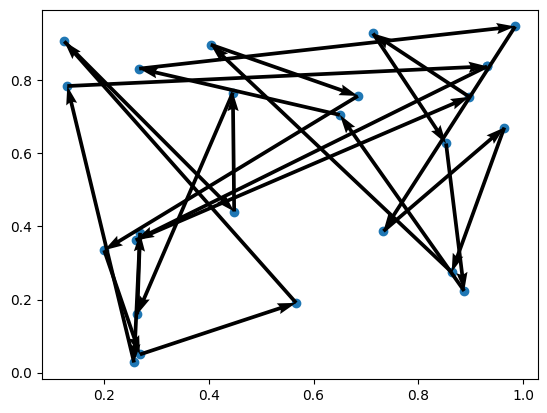

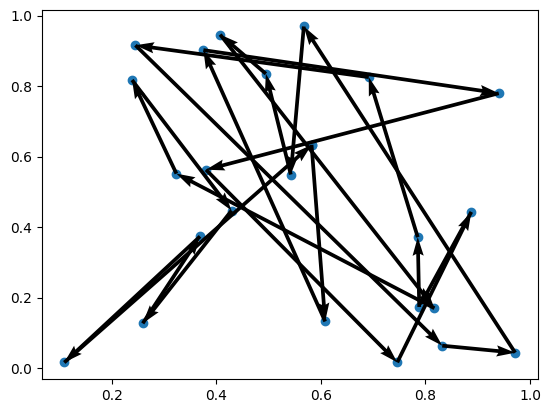

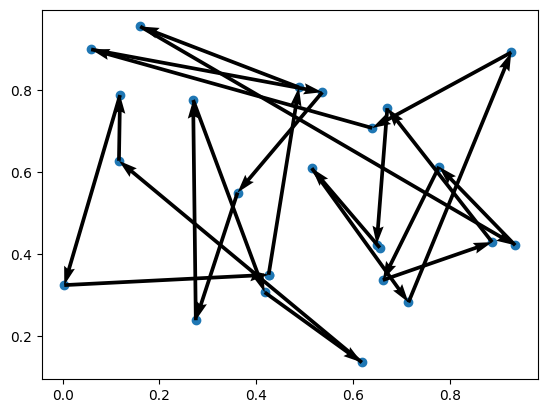

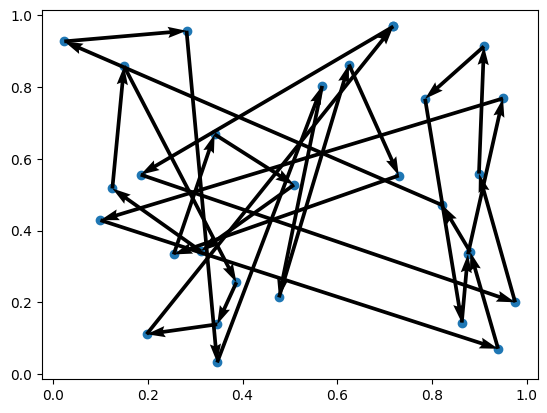

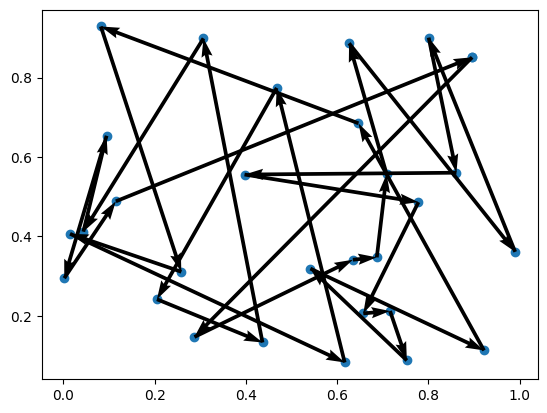

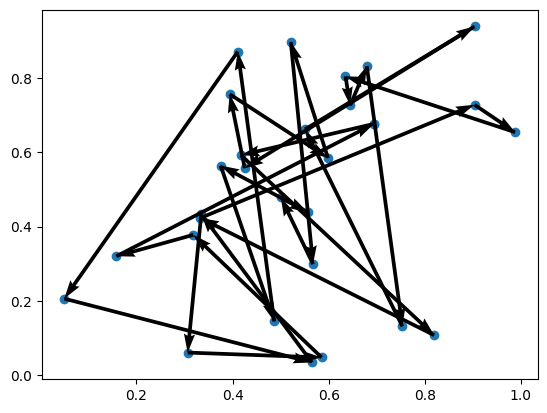

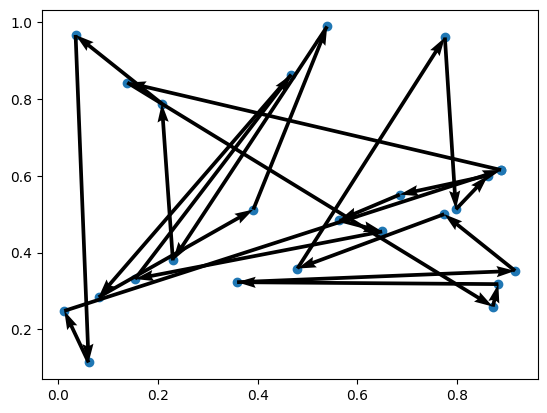

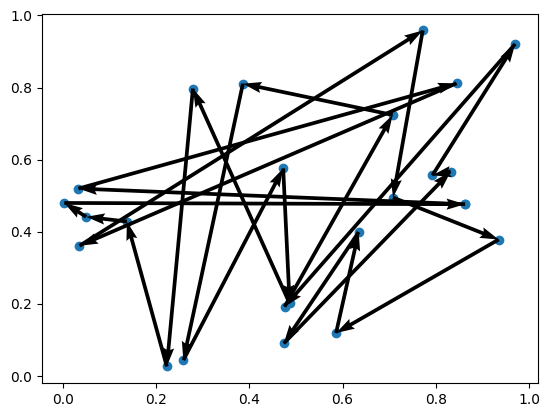

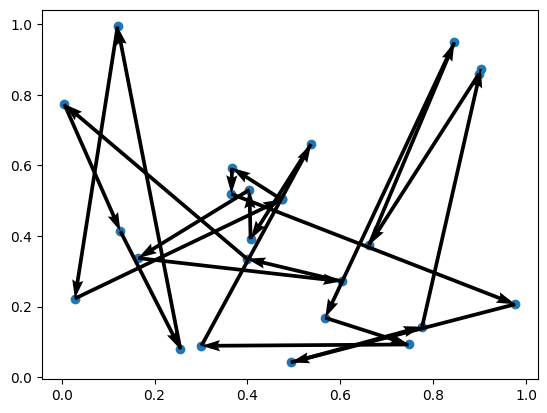

In [30]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate multiple different problem instances
td_init_1 = env.reset(batch_size=[3]).to(device)
td_init_2 = env.reset(batch_size=[3]).to(device)
td_init_3 = env.reset(batch_size=[3]).to(device)

policy = policy.to(device)

# Test on first set of problems
out_1 = policy(td_init_1.clone(), env=env, phase="test", decode_type="greedy", return_actions=True)
actions_untrained_1 = out_1['actions'].cpu().detach()
rewards_untrained_1 = out_1['reward'].cpu().detach()

print("Problem Set 1:")
for i in range(3):
    num_nodes = td_init_1[i]['locs'].shape[0]
    print(f"Problem {i+1} | Nodes: {num_nodes} | Cost: {-rewards_untrained_1[i]:.3f}")
    env.render(td_init_1[i], actions_untrained_1[i])

# Test on second set of problems
out_2 = policy(td_init_2.clone(), env=env, phase="test", decode_type="greedy", return_actions=True)
actions_untrained_2 = out_2['actions'].cpu().detach()
rewards_untrained_2 = out_2['reward'].cpu().detach()

print("\nProblem Set 2:")
for i in range(3):
    num_nodes = td_init_2[i]['locs'].shape[0]
    print(f"Problem {i+1} | Nodes: {num_nodes} | Cost: {-rewards_untrained_2[i]:.3f}")
    env.render(td_init_2[i], actions_untrained_2[i])

# Test on third set of problems
out_3 = policy(td_init_3.clone(), env=env, phase="test", decode_type="greedy", return_actions=True)
actions_untrained_3 = out_3['actions'].cpu().detach()
rewards_untrained_3 = out_3['reward'].cpu().detach()

print("\nProblem Set 3:")
for i in range(3):
    num_nodes = td_init_3[i]['locs'].shape[0]
    print(f"Problem {i+1} | Nodes: {num_nodes} | Cost: {-rewards_untrained_3[i]:.3f}")
    env.render(td_init_3[i], actions_untrained_3[i])

# Keep original variables for compatibility with later cells
td_init = td_init_1
actions_untrained = actions_untrained_1
rewards_untrained = rewards_untrained_1

In [31]:
trainer = RL4COTrainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params | Mode 
----------------------------------------------------------
0 | env      | TSPEnv               | 0      | train
1 | policy   | PointerNetworkPolicy | 331 K  | eval 
2 | baseline | WarmupBaseline       | 331 K  | train
----------------------------------------------------------
662 K     Trainable params
0         Non-trainable params
662 K     Total params
2.649     Total estimated model params size (MB)
15        Modules in train mode
11        Modules in eval mode


/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 196/196 [00:05<00:00, 34.35it/s, v_num=7, train/reward=-8.60, train/loss=3.810]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 196/196 [00:06<00:00, 28.33it/s, v_num=7, train/reward=-10.1, train/loss=-0.896, val/reward=-8.75]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 196/196 [00:05<00:00, 32.72it/s, v_num=7, train/reward=-8.40, train/loss=0.645, val/reward=-8.24]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 196/196 [00:06<00:00, 28.70it/s, v_num=7, train/reward=-9.94, train/loss=-1.40, val/reward=-8.15]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 196/196 [00:06<00:00, 31.14it/s, v_num=7, train/reward=-9.36, train/loss=2.090, val/reward=-8.07]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 196/196 [00:06<00:00, 30.64it/s, v_num=7, train/reward=-9.23, train/loss=0.549, val/reward=-8.01] 
Validation: |          | 0/? [00:

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 196/196 [00:07<00:00, 27.07it/s, v_num=7, train/reward=-10.1, train/loss=0.355, val/reward=-7.94]


Comparison: Problem Set 1
Problem 1 | Nodes: 24


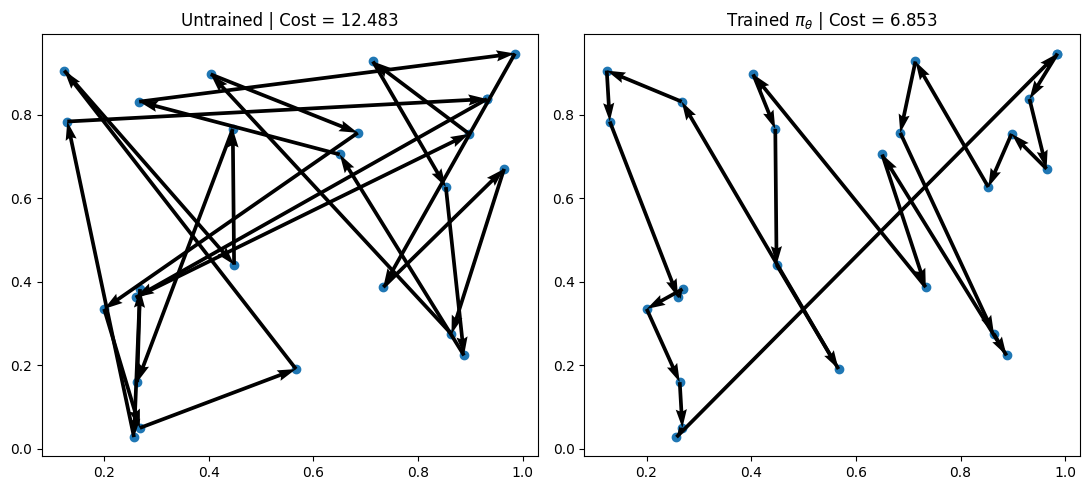

Problem 2 | Nodes: 24


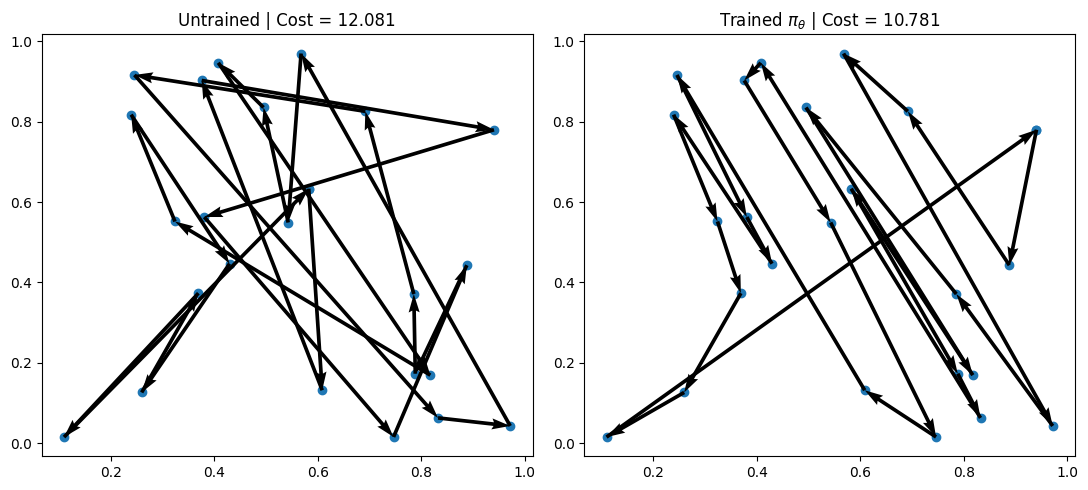

Problem 3 | Nodes: 24


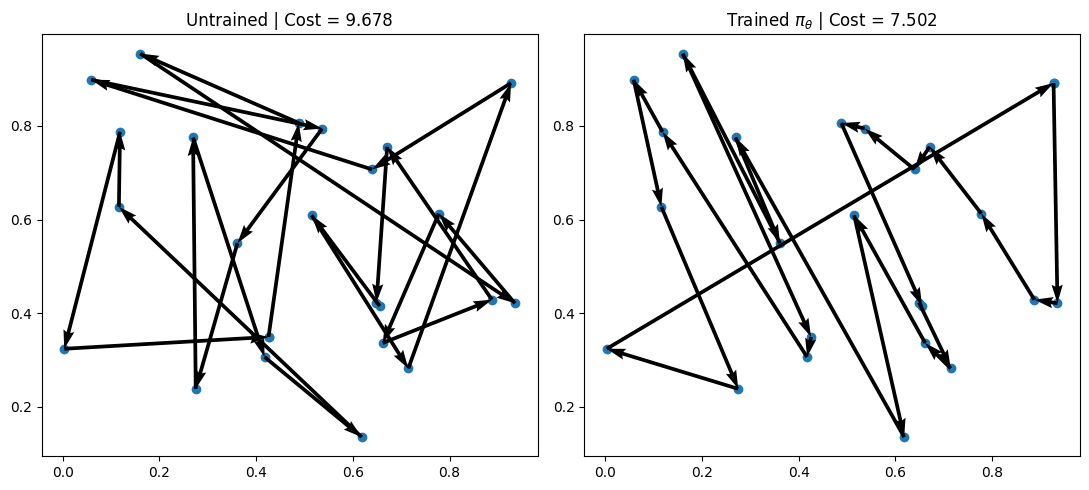


Comparison: Problem Set 2
Problem 1 | Nodes: 29


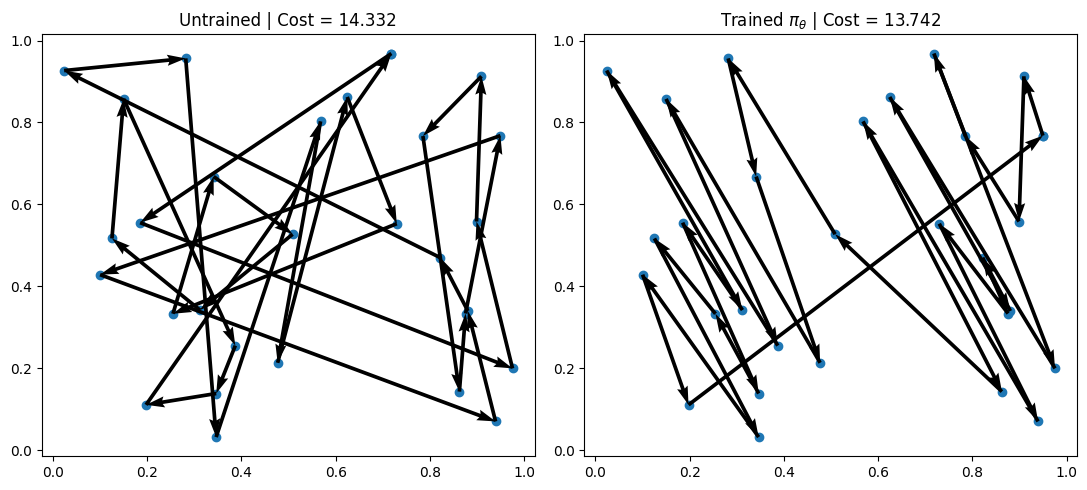

Problem 2 | Nodes: 29


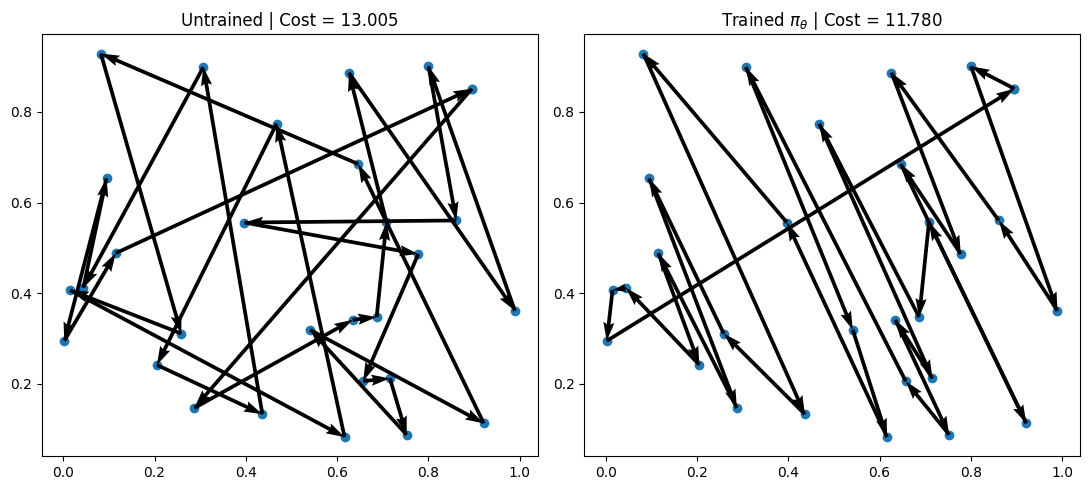

Problem 3 | Nodes: 29


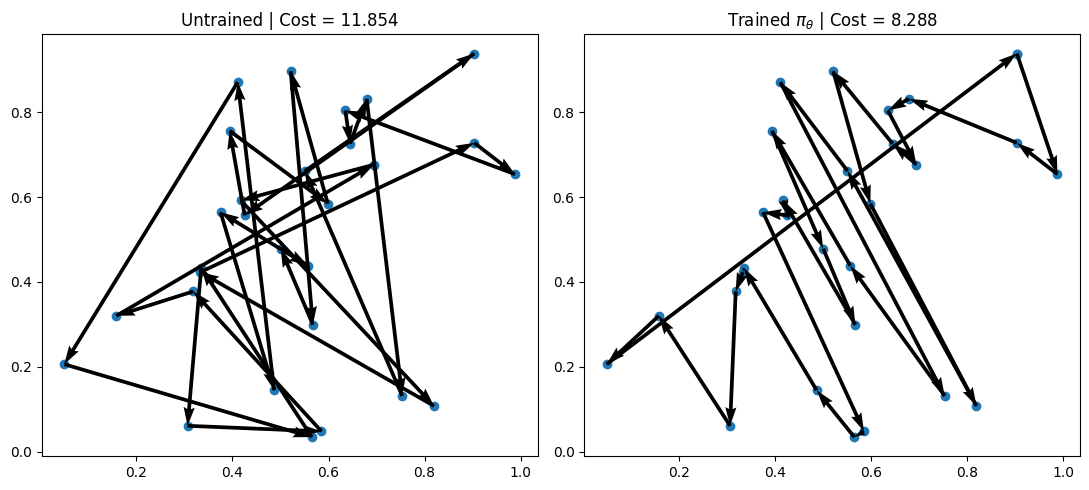


Comparison: Problem Set 3
Problem 1 | Nodes: 24


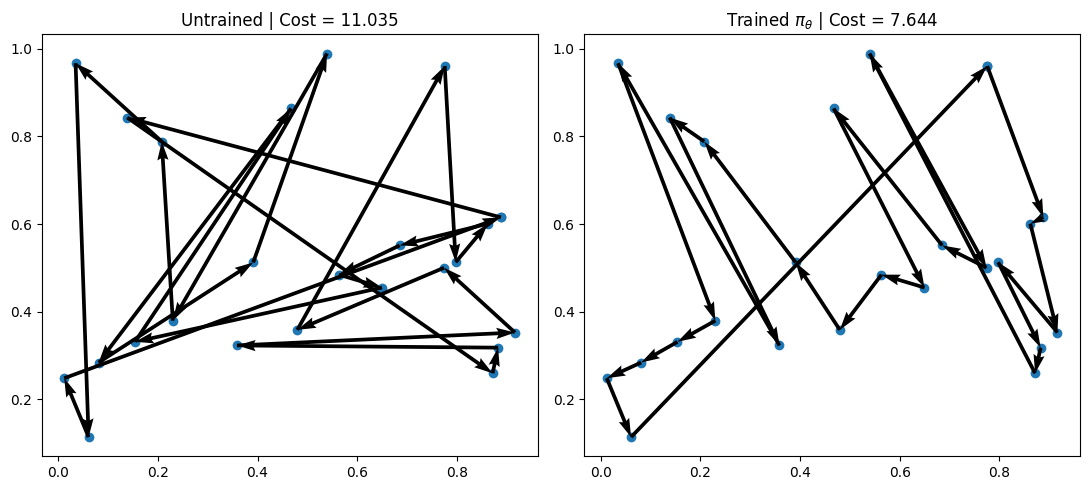

Problem 2 | Nodes: 24


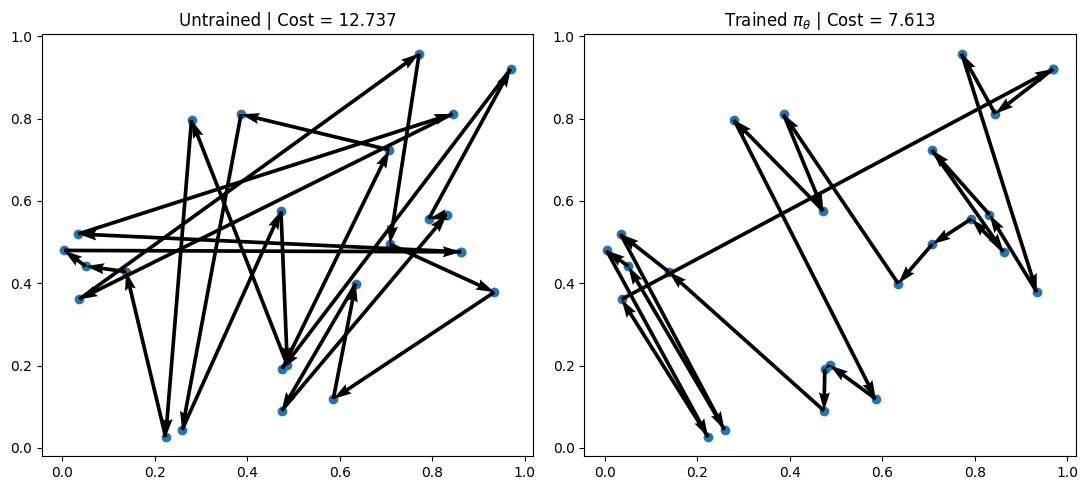

Problem 3 | Nodes: 24


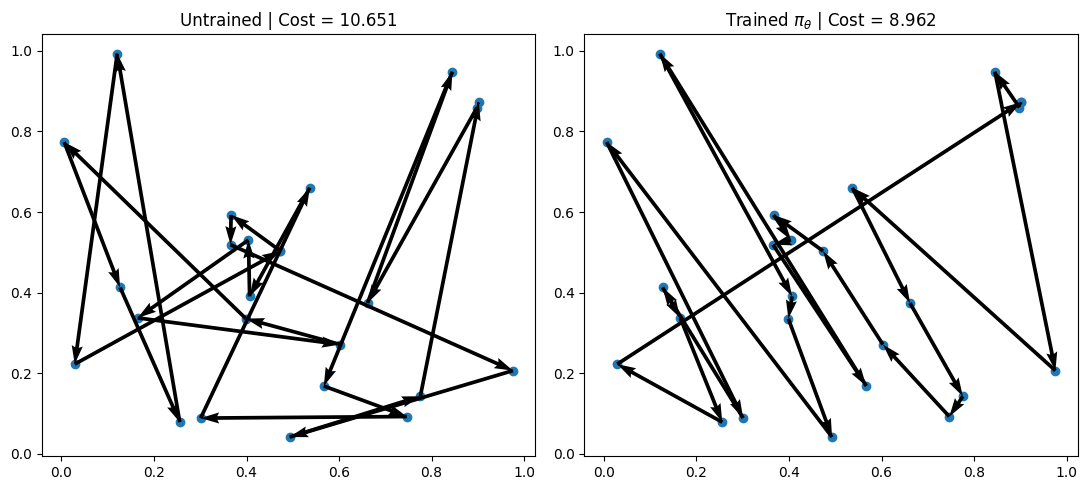

In [33]:
# Greedy rollouts over trained model (test on all 3 problem sets)
policy = model.policy.to(device)

# Test trained model on first set of problems
out_trained_1 = policy(td_init_1.clone(), env=env, phase="test", decode_type="greedy", return_actions=True)
actions_trained_1 = out_trained_1['actions'].cpu().detach()
rewards_trained_1 = out_trained_1['reward'].cpu().detach()

# Test trained model on second set of problems
out_trained_2 = policy(td_init_2.clone(), env=env, phase="test", decode_type="greedy", return_actions=True)
actions_trained_2 = out_trained_2['actions'].cpu().detach()
rewards_trained_2 = out_trained_2['reward'].cpu().detach()

# Test trained model on third set of problems
out_trained_3 = policy(td_init_3.clone(), env=env, phase="test", decode_type="greedy", return_actions=True)
actions_trained_3 = out_trained_3['actions'].cpu().detach()
rewards_trained_3 = out_trained_3['reward'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt

print("Comparison: Problem Set 1")
for i, td in enumerate(td_init_1):
    num_nodes = td_init_1[i]['locs'].shape[0]
    print(f"Problem {i+1} | Nodes: {num_nodes}")
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained_1[i], ax=axs[0])
    env.render(td, actions_trained_1[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained_1[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f" | Cost = {-rewards_trained_1[i].item():.3f}")
    plt.tight_layout()
    plt.show()

print("\nComparison: Problem Set 2")
for i, td in enumerate(td_init_2):
    num_nodes = td_init_2[i]['locs'].shape[0]
    print(f"Problem {i+1} | Nodes: {num_nodes}")
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained_2[i], ax=axs[0])
    env.render(td, actions_trained_2[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained_2[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f" | Cost = {-rewards_trained_2[i].item():.3f}")
    plt.tight_layout()
    plt.show()

print("\nComparison: Problem Set 3")
for i, td in enumerate(td_init_3):
    num_nodes = td_init_3[i]['locs'].shape[0]
    print(f"Problem {i+1} | Nodes: {num_nodes}")
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained_3[i], ax=axs[0])
    env.render(td, actions_trained_3[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained_3[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f" | Cost = {-rewards_trained_3[i].item():.3f}")
    plt.tight_layout()
    plt.show()

# Keep original variables for compatibility with later cells
actions_trained = actions_trained_1
out = out_trained_1

In [ ]:
# Optionally, save the checkpoint for later use (e.g. in tutorials/4-search-methods.ipynb)
trainer.save_checkpoint("tsp-quickstart.ckpt")